<a href="https://colab.research.google.com/github/Kushagratandon12/Intel_Image-Classification/blob/tensorflow_model/iNTEL_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection From Kaggle

In [2]:
!pip install kaggle
# # from google.colab import files
# # files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip '/content/intel-image-classification.zip'

#####NOTES ON 
# https://www.notion.so/TensorFlow-2-O-Notes-ff1463fb14f54affa0d4e4390c1152dc

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [3]:
import numpy as np
import pandas as pd
import glob
import os 
from os import path
import gc
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
from google.colab import files
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.applications.resnet_v2 import  ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Image Pre-Processing


In [4]:
train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_test/seg_test'
pred_path = '/content/seg_pred/seg_pred'

# Image Data Generator - Keras

In [5]:
train_df = keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle = True
)
classes = train_df.class_names
print(classes)

Found 14034 files belonging to 6 classes.
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


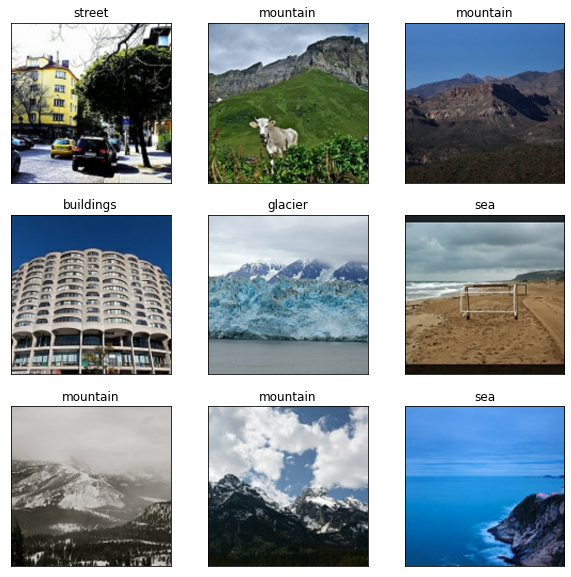

In [6]:
plt.figure(figsize=(10,10))

for images, labels in train_df.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i]/255)
    print(images[i].shape) 
    plt.title(classes[labels[i]])
    plt.xticks([])
    plt.yticks([])

# IMAGE AGUMENTATION

In [7]:
TRAINING_DIR = '/content/seg_train/seg_train'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    zoom_range = 0.2,
)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 14034 images belonging to 6 classes.


In [8]:
VALIDATION_DIR = '/content/seg_test/seg_test'
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )#YOUR CODE HERE
validation_generator = train_datagen.flow_from_directory(VALIDATION_DIR,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 3000 images belonging to 6 classes.


# Creation / Using Of Model

In [9]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
EPOCHS = 10

CLASS_NAMES = np.array([item for item in os.listdir(train_path)])
print (CLASS_NAMES)

['buildings' 'forest' 'glacier' 'sea' 'street' 'mountain']


In [10]:
def define_model(n_layers=150,BASE_MODEL='ResNet50V2'):
    if BASE_MODEL =='ResNet50V2':
        # Pre-trained model with MobileNetV2
        base_model = ResNet50V2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=False
        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.2)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
    
    if BASE_MODEL =='InceptionV3':
        base_model = InceptionV3(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=False
        
        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.5)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
    return model

# define Model 
model= define_model(BASE_MODEL='InceptionV3')

#Compilation of the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(lr=0.001), 
    metrics=['accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
#Last Layer Was Enabled Using My Developed Model
#model.summary()

In [11]:
checkpoint_path = "/content/Custom_Weights"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only=True,monitor='val_loss', verbose=1,
                            save_best_only=True,mode='min')
# lr_callback = LearningRateScheduler(lr_scheduler, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.0001)

In [20]:
history = model.fit(train_generator,
                              epochs=5,
                              verbose=1,
                              shuffle=True,
                              validation_data=validation_generator,
                    callbacks=[cp_callback,learning_rate_reduction])

Epoch 1/5
439/439 [==============================] - 240s 546ms/step - loss: 0.0675 - accuracy: 0.9772 - val_loss: 0.2746 - val_accuracy: 0.9220

Epoch 00001: val_loss did not improve from 0.21436
Epoch 2/5
439/439 [==============================] - 239s 545ms/step - loss: 0.0598 - accuracy: 0.9801 - val_loss: 0.2540 - val_accuracy: 0.9240

Epoch 00002: val_loss did not improve from 0.21436
Epoch 3/5
439/439 [==============================] - 239s 545ms/step - loss: 0.0480 - accuracy: 0.9851 - val_loss: 0.2745 - val_accuracy: 0.9267

Epoch 00003: val_loss did not improve from 0.21436
Epoch 4/5
439/439 [==============================] - 240s 547ms/step - loss: 0.0465 - accuracy: 0.9847 - val_loss: 0.3157 - val_accuracy: 0.9233

Epoch 00004: val_loss did not improve from 0.21436
Epoch 5/5
439/439 [==============================] - 240s 547ms/step - loss: 0.0385 - accuracy: 0.9882 - val_loss: 0.3264 - val_accuracy: 0.9263

Epoch 00005: val_loss did not improve from 0.21436


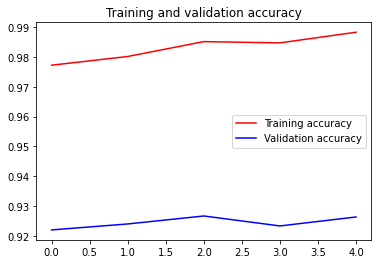

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [15]:
from google.colab import drive
drive.mount('Kushagra')

Mounted at Kushagra


In [16]:
tf.saved_model.save(model,'/content/Kushagra/MyDrive/Colab Notebooks')

INFO:tensorflow:Assets written to: /content/Kushagra/MyDrive/Colab Notebooks/assets


In [18]:
model.save('/content/Kushagra/MyDrive/Colab Notebooks/intel_weight.h5')

# Model Evaluation

In [21]:
import random
img = glob.glob('/content/seg_pred/seg_pred/*.jpg')
img_select = random.randint(1,len(img))
image_path = img[img_select]
print(image_path)/

SyntaxError: ignored

In [ ]:
image_show = plt.imread(image_path)
plt.imshow(image_show)

In [ ]:
shape = (256,256)
def decode_img(image_path,shape):
    img = tf.keras.preprocessing.image.load_img(image_path,target_size=(shape))
    img = tf.keras.preprocessing.image.img_to_array(img) # converted to ndarray 
    img = img.astype(np.float32)/255.0
    img = np.expand_dims(img,axis=0)
    return img

In [ ]:
img = decode_img(image_path,shape)
pred = saved_model.predict(img)
idx = np.argmax(pred)

In [ ]:
print(idx)
print(classes[idx])

1
forest


In [ ]:
def model_pred(image_path):
    img = image.load_img(image_path, target_size=(256, 256))
    img = image.img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    idx = np.argmax(saved_model.predict(img))
    print(idx)
    return idx

In [ ]:
pred = model_pred(image_path)
print(classes[pred])

ValueError: ignored

#Using TENSORFLOW LITE 


In [ ]:
import numpy as np
import tensorflow as tf
import cv2

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/tflite_model")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
img = cv2.resize(img,(160,160))
img=img/255.0

In [ ]:
# Test model on input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.expand_dims(img,axis=0), dtype=np.float32)
print(input_data.shape)
print(input_data.dtype)

interpreter.set_tensor(input_details[0]['index'], input_data)

# Model predict
interpreter.invoke()
output_details = interpreter.get_output_details()
# time to predict 
output_data = interpreter.get_tensor(output_details[0]['index'])
results = np.squeeze(output_data)
pred = np.argmax(results)
print(pred)

(1, 160, 160, 3)
float32
4


In [ ]:
print(classes[pred])

sea
